In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# --- 1. Load dataset ---
df = pd.read_csv("C:/Users/Liwia/Downloads/clean_data.csv")

# --- 2. Identify food name column ---
name_candidates = [c for c in df.columns if "name" in c.lower()]
name_col = name_candidates[0] if name_candidates else df.columns[0]

# --- 3. Identify nutrient columns ---
def find_col(df, keys):
    keys = [k.lower() for k in keys]
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in keys):
            return c
    return None

cols = {
    "PROTEIN": find_col(df, ["prot", "protein"]),
    "VITAMIN_C": find_col(df, ["vitc", "vit c", "vitamin c"]),
    "VITAMIN_D": find_col(df, ["vitd", "vit d", "vitamin d"]),
}
cols = {k: v for k, v in cols.items() if v is not None}

# --- 4. Helper function for DBSCAN clustering ---
def dbscan_cluster(series, eps=0.5, min_samples=5):
    s = pd.to_numeric(series, errors="coerce")
    mask = s.notna()
    X = s[mask].to_numpy().reshape(-1, 1)
    if len(X) == 0:
        return pd.Series(index=series.index, dtype="Int64"), np.array([])

    # Standardize the data before DBSCAN
    X_scaled = StandardScaler().fit_transform(X)

    # Run DBSCAN (density-based clustering)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X_scaled)
    labels = db.labels_

    # Map cluster labels to ranks by mean nutrient value
    # DBSCAN may assign -1 to noise points (unclustered)
    valid_mask = labels != -1
    if valid_mask.sum() == 0:
        return pd.Series(index=series.index, dtype="Int64"), np.array([])

    cluster_means = {}
    for cl in np.unique(labels[valid_mask]):
        cluster_means[cl] = X[labels == cl].mean()
    ranked_clusters = sorted(cluster_means, key=cluster_means.get)

    # Map cluster labels to "Low", "Medium", "High" (up to 3 clusters)
    rank_map = {c: i for i, c in enumerate(ranked_clusters)}
    mapped = pd.Series(index=series.index, dtype="object")
    mapped.loc[mask] = [rank_map.get(l, -1) for l in labels]
    label_map = {0: "Low", 1: "Medium", 2: "High"}
    mapped = mapped.map(label_map).fillna("Noise")

    return mapped, cluster_means

# --- 5. Run clustering for each nutrient ---
result = df.copy()
summaries = []

for tag, col in cols.items():
    clusters, means = dbscan_cluster(df[col], eps=0.4, min_samples=4)
    result[f"cluster_{tag}"] = clusters

    # Collect summary info
    counts = clusters.value_counts().reindex(["Low","Medium","High","Noise"], fill_value=0)
    summaries.append({
        "Nutrient": tag,
        "Column": col,
        "Low_count": counts["Low"],
        "Medium_count": counts["Medium"],
        "High_count": counts["High"],
        "Noise_count": counts["Noise"],
        "Centers": means
    })

# --- 6. Display summary ---
summary_df = pd.DataFrame(summaries)
print("\n=== DBSCAN Clustering Summary ===")
print(summary_df)

# --- 7. Show top “High” foods per nutrient ---
for tag, col in cols.items():
    print(f"\nTop foods high in {tag}:")
    mask = result[f"cluster_{tag}"] == "High"
    print(result.loc[mask, [name_col, col]].sort_values(col, ascending=False).head(10))

# --- 8. Save clustered dataset ---
output_path = Path("clustered_foods_DBSCAN.csv")
result.to_csv(output_path, index=False)
print(f"\n✅ Clustering complete! File saved to: {output_path.absolute()}")



=== DBSCAN Clustering Summary ===
    Nutrient     Column  Low_count  Medium_count  High_count  Noise_count  \
0    PROTEIN   PROT (g)       2006             0           0            1   
1  VITAMIN_C  VITC (mg)       1985             4           7           11   
2  VITAMIN_D  VITD (µg)       1995             4           0            8   

                                             Centers  
0                             {0: 8.045663010967099}  
1  {0: 4.616120906801007, 1: 80.75, 2: 117.428571...  
2     {0: 0.47448621553884707, 1: 9.049999999999999}  

Top foods high in PROTEIN:
Empty DataFrame
Columns: [Engelse naam/Food name, PROT (g)]
Index: []

Top foods high in VITAMIN_C:
                 Engelse naam/Food name  VITC (mg)
92                        Parsley fresh      125.0
889                    Horse-radish raw      120.0
536             Sweet pepper red boiled      119.0
1937  Pate vegetarian based on soya/pea      119.0
1313            Sweet pepper yellow raw      114.0
13

Dataset shape: (2007, 23)


,NEVO-code,Food group,Engelse naam/Food name,Hoeveelheid/Quantity,FAT (g),PROT (g),Carbohydrates (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),...,VITC (mg),VITA (µg),Calcium (mg),Iron (mg),Magnesium (mg),Phosphorus (mg),Potassium (mg),Sodium (mg),Zinc (mg),food_pyramid_group
0,1,Potatoes and tubers,Potatoes raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.30,...,14.0,1.0,6.0,0.5,22.0,60.0,450.0,2.0,0.37,Whole Grains
1,2,Potatoes and tubers,Potatoes new raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.30,...,25.0,0.0,6.0,0.5,14.0,60.0,450.0,2.0,0.20,Whole Grains
2,3,Potatoes and tubers,Potatoes old raw,per 100g,0.0,2.0,88.0,0.12,0.04,0.22,...,5.0,1.0,6.0,0.5,17.0,60.0,450.0,2.0,0.30,Whole Grains
3,4,Cereals and cereal products,Pasta white raw,per 100g,1.5,12.3,356.0,0.10,0.06,0.08,...,0.0,0.0,15.0,2.0,53.0,125.0,100.0,2.0,1.50,Whole Grains
4,5,Cereals and cereal products,Rice white raw,per 100g,1.0,7.0,352.0,0.04,0.03,0.12,...,0.0,0.0,10.0,0.4,13.0,100.0,100.0,2.0,1.80,Whole Grains


Numeric columns used for clustering: ['NEVO-code', 'FAT (g)', 'PROT (g)', 'Carbohydrates (kcal)', 'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)', 'VITE (mg)', 'VITC (mg)', 'VITA (µg)', 'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)']


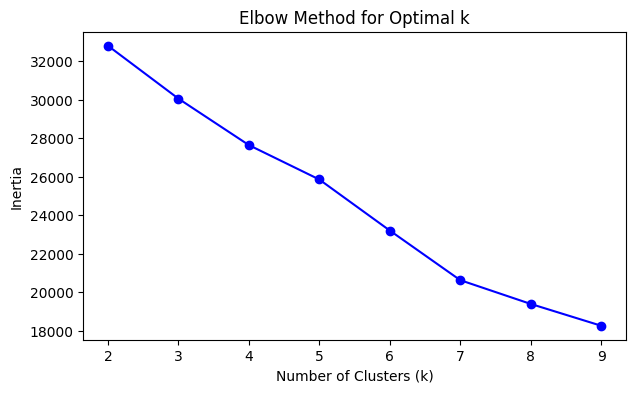

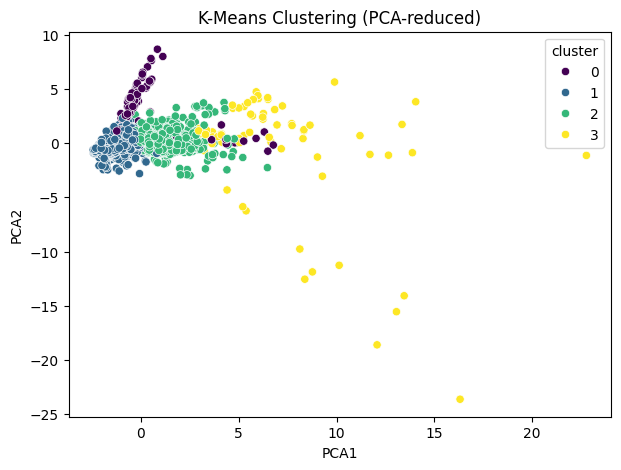

,NEVO-code,FAT (g),PROT (g),Carbohydrates (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),VITB12 (µg),VITD (µg),VITE (mg),VITC (mg),VITA (µg),Calcium (mg),Iron (mg),Magnesium (mg),Phosphorus (mg),Potassium (mg),Sodium (mg),Zinc (mg)
cluster,,,,,,,,,,,,,,,,,,,
0,2789.21,65.25,1.18,595.86,0.21,0.25,0.29,0.53,4.89,16.62,0.01,512.07,43.64,0.12,2.49,23.86,38.45,177.38,0.11
1,2260.95,4.96,3.11,147.61,0.05,0.07,0.06,0.12,0.17,0.98,8.15,71.35,42.27,0.67,14.59,56.91,164.03,277.64,0.40
2,2268.85,14.43,15.30,296.70,0.21,0.18,0.24,1.22,0.66,1.71,2.83,106.90,62.79,2.11,46.63,219.00,369.75,378.28,2.03
3,1895.03,26.29,23.94,381.47,0.33,0.73,0.30,10.00,0.58,4.15,4.69,2272.90,493.16,5.58,153.66,593.14,623.24,425.15,5.21


Clustered dataset saved as clustered_data.csv


In [5]:
# --- 1. Import libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Load dataset ---
df = pd.read_csv("C:/Users/Liwia/Downloads/clean_data.csv")

print("Dataset shape:", df.shape)
display(df.head())

# --- 3. Select numeric columns for clustering ---
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns used for clustering:", numeric_cols)

# --- 4. Handle missing values ---
df_clean = df.dropna(subset=numeric_cols).copy()

# --- 5. Standardize numeric features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[numeric_cols])

# --- 6. Choose optimal number of clusters using Elbow method ---
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# --- 7. Run K-Means with chosen number of clusters ---
optimal_k = 4  # you can adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# --- 8. Visualize clusters using PCA (2D projection) ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
plt.title("K-Means Clustering (PCA-reduced)")
plt.show()

# --- 9. Analyze cluster means ---
cluster_summary = df_clean.groupby('cluster')[numeric_cols].mean().round(2)
display(cluster_summary)

# --- 10. Optional: Save clustered dataset ---
df_clean.to_csv("clustered_data.csv", index=False)
print("Clustered dataset saved as clustered_data.csv")
